In [85]:
# %matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

import os

from pandas import DataFrame
from numpy import ndarray

In [86]:
PATH = "../results"

# standard units are feet, seconds, radians
conversion_to_standard = {
    "feet": 1.0,
    "foot": 1.0,
    "ft": 1.0,
    "seconds": 1.0,
    "s": 1.0,
    "minutes": 60,
    "m": 60,
    "hours": 60 * 60,
    "h": 60 * 60,
    "fps": 1.0,
    "mph": 1.46667,
    "radians": 1.0,
    "degrees": np.pi / 180,
    "radians/sec": 1.0,
    "radians/min": 1.0 / 60.0,
    "degrees/sec": np.pi / 180,
    "degrees/min": np.pi / 180 / 60.0,
}

In [87]:
def convert_units(value: float, frm: str, to:str) -> float:
    return value * conversion_to_standard[frm] / conversion_to_standard[to]

def convert_all(column, frm: str, to:str):
    return [convert_units(v, frm, to) for v in column]

def prepare(df:DataFrame, units: dict[str, tuple[str, str]] = {}) -> DataFrame:
    df['is_violation'] = np.where(
        (df['contactLevel'] != 'none') | ("violation" in df['contactEvents']) | ("collision" in df['contactEvents']), 
        1, 0)
    
    for c, (frm, to) in units.items():
        if c in df.columns:
            df[c] = convert_all(df[c], frm, to)

    df = df.round(2)
    return df

def add_heat_legend(values, element, ax):
    np.unique(values)[::-1].sort()
    colors = [ element.cmap(element.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label=f"{values[i]} violations") for i in range(len(values)) ]
        
    ax.legend(handles=patches, bbox_to_anchor=(-0.18, 1), loc=2, borderaxespad=0.0)

def heatmap(df: pd.DataFrame, x_key: str, y_key: str, title:str, skip_count_x=0, skip_count_y=0, **kwargs):
    df = df.groupby([x_key,y_key], as_index=False).agg({'is_violation': np.sum})
    df = df.pivot(columns=x_key, index=y_key, values="is_violation")
    
    fig, ax = plt.subplots()
    im = ax.imshow(np.flip(df.to_numpy(), 0), **kwargs)
    ax.set_title(title)
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    
    ax.set_xticks(np.arange(0, len(df.columns), 1)[::(skip_count_x + 1)])
    ax.set_yticks(np.arange(0, len(df.index), 1)[::-(skip_count_y + 1)])
    ax.set_xticklabels(list(map(lambda v: round(v, 2), df.columns[::(skip_count_x + 1)])))
    ax.set_yticklabels(list(map(lambda v: round(v, 2), df.index[::(skip_count_y + 1)])))
    
    values = np.unique(df.to_numpy().flatten())
    
    add_heat_legend(values, im, ax)
    
def isolate(df: pd.DataFrame, cols: dict): # keys:list[str], values:list
    exp = None
    for k, v in cols.items():
        if exp is None:
            exp = df[k] == v
        else:
            exp &= df[k] == v
            
    return df[exp]

# def subtract(a: DataFrame, b: DataFrame, keys: list[str]) -> DataFrame:
    

def plot_point_cloud(df: pd.DataFrame, x_key: str, y_key: str, z_key: str, title: str, point_radius: float = None, axes_titles={}, use_values_as_ticks = False, tick_skip=(0,0,0)):
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(8)
    fig.tight_layout()
    ax = fig.add_subplot(projection='3d')
    
    x = df[x_key].unique()
    x.sort()
    y = df[y_key].unique()
    y.sort()
    z = df[z_key].unique()
    z.sort()
    
    print("Axes: ", x, y, z, sep="\n")
    
    points = []
    temps = []
    # temps = df['is_violation']
    
    
    for zi in z:
        for yi in y:
            for xi in x:
                points.append((xi, yi, zi))
                temps.append(isolate(df, {x_key:xi, y_key:yi, z_key:zi})['is_violation'])

    # print(np.array(temps).shape)

    s = point_radius ** 2 if point_radius else None

    print(f"Num points: {len(points)}, shape: {np.array(points).shape}")

    scat = ax.scatter(*np.array(points).T, c=temps, alpha=0.5, s=s)
    
    x_title, y_title, z_title = [
        axes_titles[key] if key in axes_titles else key for key in [x_key, y_key, z_key]
    ]
    
    if use_values_as_ticks:
        x_l = x[::1 + tick_skip[0]]
        y_l = y[::1 + tick_skip[1]]
        z_l = z[::1 + tick_skip[2]]
        
        ax.set_xticklabels(x_l)
        ax.set_yticklabels(y_l)
        ax.set_zticklabels(z_l)
        ax.set_xticks(x_l)
        ax.set_yticks(y_l)
        ax.set_zticks(z_l)
    
    ax.set_xlabel(x_title, labelpad=10)
    ax.set_ylabel(y_title, labelpad=10)
    ax.set_zlabel(z_title, labelpad=10)
    ax.set_title(title)
    
    add_heat_legend(np.unique(np.array(temps[::-1]).flatten()), scat, ax)
        
    # temps = [temps[-1], temps[len(temps)//2], temps[0]]
    # add_temp_legend(np.unique(temps), scat, ax)
    
def get_relevant_axes(name:str) -> tuple[str, str, str]:
    h = "drone_horizontal_turn_rate"
    v = "drone_ascent_rate"
    
    x = "drone_speed" 
    y = h if "horizontal" in name else v if "vertical" in name else None
    z = "drone_response_distance"
    return x, y, z

def title_case(words: list[str]) -> list[str]:
    return [f"{w[0].upper()}{w[1:].lower()}" for w in words]

def create_title(name:str) -> str:
    name = name.split(".")[0] # remove extension
    return " ".join(title_case(name.split("-")))

def nearest_idx(arr: np.ndarray, value: float):
    idx = np.absolute(arr - value).argmin()
    return idx

In [88]:
df = DataFrame({
    "a": [1, 2, 3, 4],
    "b": [6 * np.pi/180, 8, 10, 12],
})

convert_all(df["b"], "degrees/sec", "degrees/sec")

[0.10471975511965977, 8.0, 10.0, 12.0]

Converging Norm Horizontal Violations
Axes: 
[44.   49.87 55.73 61.6  67.47 73.33]
[ 6.  8. 10. 12. 14. 16. 18. 20.]
[ 3000.  3700.  4400.  5100.  5800.  6500.  7200.  7900.  8600.  9300.
 10000.]
Num points: 528, shape: (528, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


worst case: 5100.0
Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.
49.86678 168.81371699999997 13.89
actual
49.87 168.67 14.0
% error
0.01%, -0.09%, 0.79%, 
Converging Norm Vertical Violations
Axes: 
[44.   49.87 55.73 61.6  67.47 73.33]
[ 8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]
[ 3000.  3700.  4400.  5100.  5800.  6500.  7200.  7900.  8600.  9300.
 10000.]
Num points: 726, shape: (726, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


worst case: nan
Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.
49.86678 168.81371699999997 8.2 26.25
actual
49.87 168.67 8.0 26.0
% error
0.01%, -0.09%, -2.44%, -0.95%, 
Headon Norm Horizontal Violations
Axes: 
[44.   49.87 55.73 61.6  67.47 73.33]
[ 6.  8. 10. 12. 14. 16. 18. 20.]
[ 3000.  3700.  4400.  5100.  5800.  6500.  7200.  7900.  8600.  9300.
 10000.]
Num points: 528, shape: (528, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


worst case: 10000.0
Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.
49.86678 168.81371699999997 13.89
actual
49.87 168.67 14.0
% error
0.01%, -0.09%, 0.79%, 
Headon Norm Vertical Violations
Axes: 
[44.   49.87 55.73 61.6  67.47 73.33]
[ 8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]
[ 3000.  3700.  4400.  5100.  5800.  6500.  7200.  7900.  8600.  9300.
 10000.]
Num points: 726, shape: (726, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


worst case: 10000.0
Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.
49.86678 168.81371699999997 8.2 26.25
actual
49.87 168.67 8.0 26.0
% error
0.01%, -0.09%, -2.44%, -0.95%, 
Overtaking Norm Horizontal Violations
Axes: 
[44.   49.87 55.73 61.6  67.47 73.33]
[ 6.  8. 10. 12. 14. 16. 18. 20.]
[ 3000.  3700.  4400.  5100.  5800.  6500.  7200.  7900.  8600.  9300.
 10000.]
Num points: 528, shape: (528, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


worst case: 9300.0
Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.
49.86678 168.81371699999997 13.89
actual
49.87 168.67 14.0
% error
0.01%, -0.09%, 0.79%, 
Overtaking Norm Vertical Violations
Axes: 
[44.   49.87 55.73 61.6  67.47 73.33]
[ 8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]
[ 3000.  3700.  4400.  5100.  5800.  6500.  7200.  7900.  8600.  9300.
 10000.]
Num points: 726, shape: (726, 3)


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_l)
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\1280476878.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(z_l)


worst case: 6500.0
Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.
49.86678 168.81371699999997 8.2 26.25
actual
49.87 168.67 8.0 26.0
% error
0.01%, -0.09%, -2.44%, -0.95%, 


PermissionError: [Errno 13] Permission denied: 'recommendations.csv'

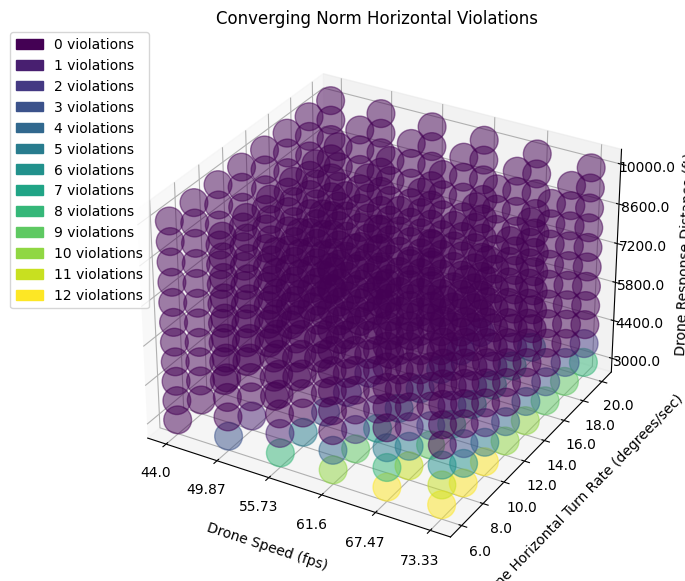

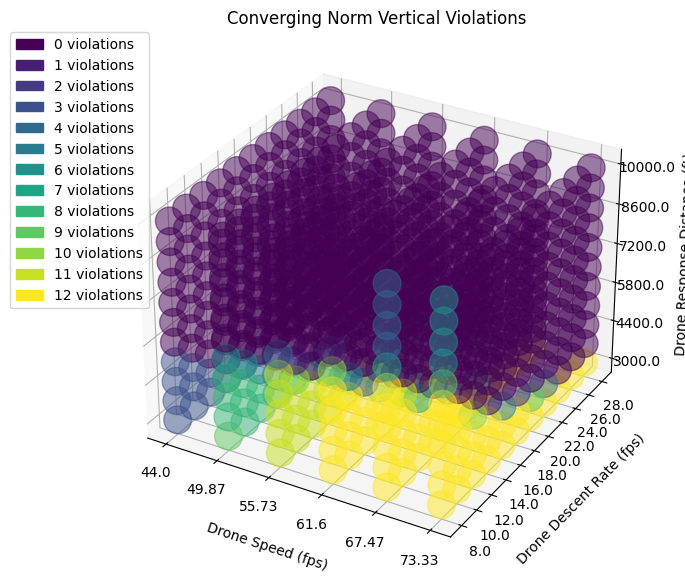

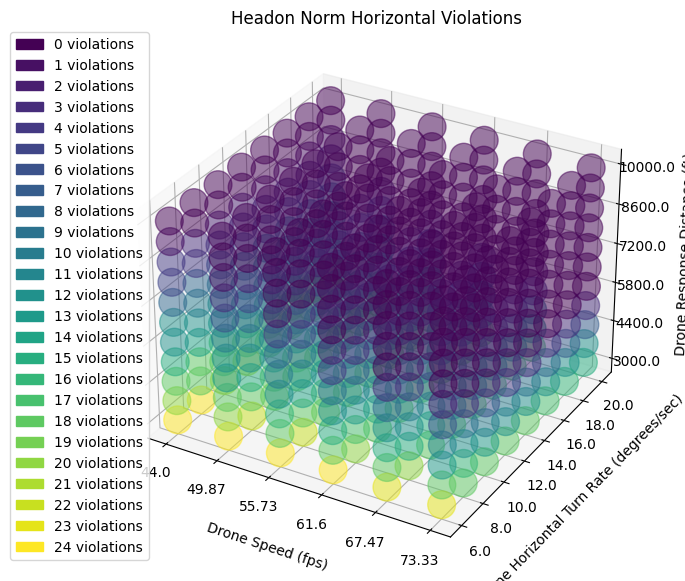

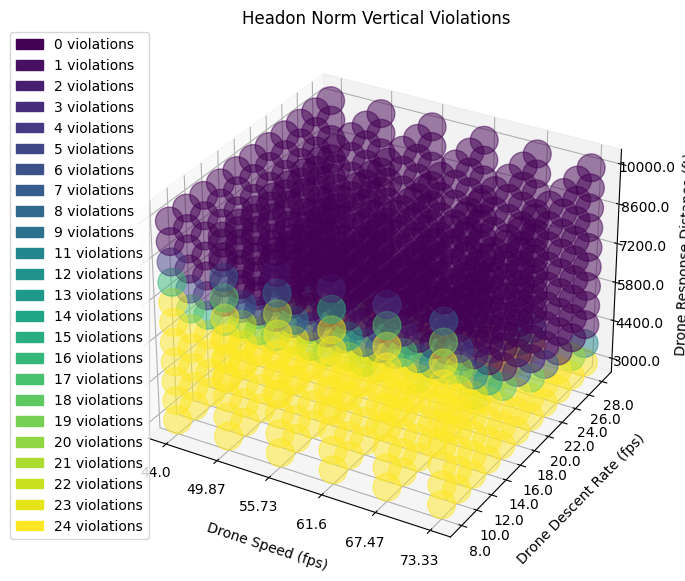

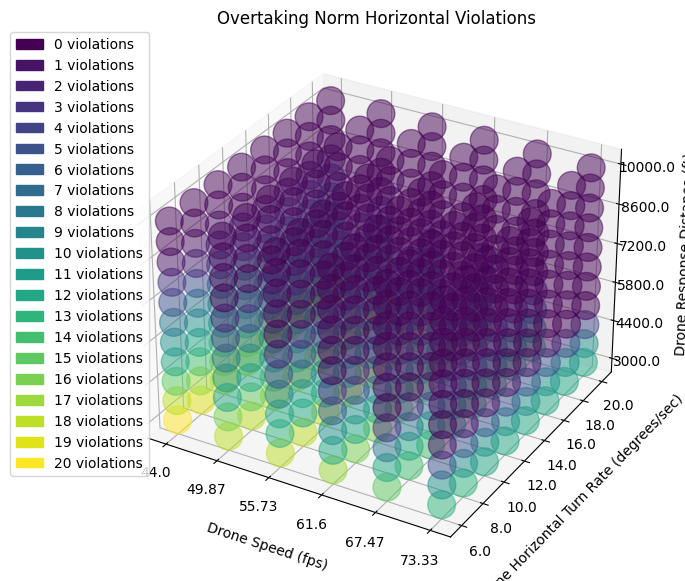

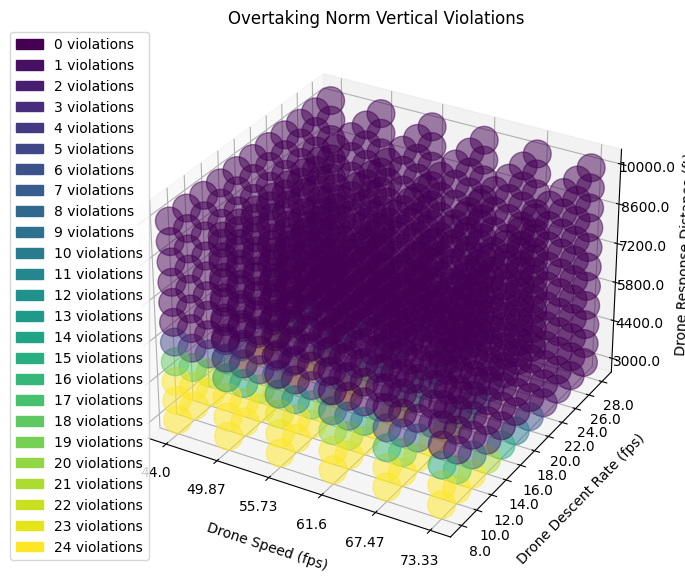

In [89]:

conversions = {
    "drone_speed": ("mph", "fps"),
    "heli_speed": ("mph", "fps"),
    "drone_response_distance": ("ft", "ft"),
    "drone_horizontal_turn_rate": ("degrees/sec", "degrees/sec"),
}

# physical test params
h_speed = 115.1 * 1.46667
d_speed = 34.0 * 1.46667
turn_rate = 13.89
descent_rate = 8.2
descent_rate_max = 26.25

scenario = []
response_distance_low = []
response_distance_high = []
response_distance_worst = []
rd_max_violation = []

for fn in os.listdir(PATH)[1:]:
    # if "headon-norm-horizontal" not in fn:
    if "adverse" in fn:
        continue
    
    fn_noext = fn.split('.')[0]
    title = create_title(fn)
    scenario.append(title)
    
    print(title)
    
    df = pd.read_csv(f"{PATH}/{fn}")
    df = prepare(df, conversions)
    df.describe().to_csv(f"tables/{fn_noext}-description.csv")
    
    axes = get_relevant_axes(fn)
    axes_titles = {
        **{axis: ' '.join(title_case(axis.split('_'))) for axis in axes},
        **{axis: f"{' '.join(title_case(axis.split('_')))} ({conv[1]})" for axis, conv in conversions.items()}
    }
    
    if "drone_ascent_rate" in axes:
        axes_titles["drone_ascent_rate"] = "Drone Descent Rate (fps)"
        df["drone_ascent_rate"] = -df["drone_ascent_rate"]
    
    
    # print(axes_titles)
    # print(axes)
    # violations = isolate(df, {"is_violation": 1})    
    violations = df.groupby(list(axes), as_index=False).agg({
        "is_violation": "sum",
    })
    
    plot_point_cloud(violations, *axes, title=title, point_radius=20, axes_titles=axes_titles, use_values_as_ticks=True, tick_skip=(0,0,1))
    # plt.show()
    plt.savefig(f"figures/{fn_noext}-3dplot.png")

    # find all safe combinations of drone params    
    # safe = isolate(
    #     df.groupby(list(axes), as_index=False).agg(
    #         is_violation=("is_violation", "sum"),
    #         max_heli_speed=("heli_speed", "max"),
    #         min_heli_speed=("heli_speed", "min"),
    #     # df.groupby(list(axes), as_index=False).agg({
    #     #     "is_violation": "sum",
    #     #     "heli_speed": ["min", "max"]
    #     # }
    # ), {"is_violation": 0})
    
    # safe.to_csv(f"tables/{fn_noext}-safe.csv")
    
    
    worst_case = isolate(df.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
    
    # isolate(df.groupby([*axes], as_index=False).sum("is_violation"), {"is_violation": 0}).groupby([*axes[0:2]], as_index=False).min("drone_response_distance").drone_response_distance.min()
    # worst_case = isolate(df.groupby([*axes], as_index=False).sum("is_violation"), {"is_violation": 0}).groupby([*axes[0:2]], as_index=False).min("drone_response_distance").drone_response_distance.min()
    
    print("worst case:", worst_case)
    
    # This doesn't work, probably need to exclude violations
    # worst_case = isolate(df, {"is_violation": 0}).groupby([*axes[0:2]]).min("drone_response_distance").drone_response_distance.max()

    response_distance_worst.append(worst_case)
    
    
    if "horizontal" in fn:
        ds = df.drone_speed.unique()
        dh = df.heli_speed.unique()
        tr = df.drone_horizontal_turn_rate.unique()
        
        actual_ds = ds[nearest_idx(ds, d_speed)]
        actual_hs = dh[nearest_idx(dh, h_speed)]
        actual_tr = tr[nearest_idx(tr, turn_rate)]
        
        # it's written as ascent when it should be descent fyi
        # lo_dr = get_close_val(df, "drone_ascent_rate", descent_rate)
        # hi_dr = get_close_val(df, "drone_ascent_rate", descent_rate_max)
        
        print(f"Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.")
        print(
            d_speed,
            h_speed,
            turn_rate,
        )
        print("actual")
        print(
            actual_ds,
            actual_hs,
            actual_tr,
        )
        print("% error")
        print(
            round((actual_ds - d_speed) / d_speed * 100, 2),
            round((actual_hs - h_speed) / h_speed * 100, 2),
            round((actual_tr - turn_rate) / turn_rate * 100, 2),
            "",
            sep="%, "
        )
        
        target = df[
            (df.drone_speed == actual_ds) &
            (df.heli_speed == actual_hs) &
            (df.drone_horizontal_turn_rate == actual_tr)
        ]
        
        # target.to_csv("tmp.csv")
        
        ideal_rd = isolate(target.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
        
        # debug_test = isolate(target.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 1}).drone_response_distance.max()
        
        rd_max_violation.append(debug_test)
        
        response_distance_low.append(ideal_rd)
        response_distance_high.append(-1)
        
    else:
        ds = df.drone_speed.unique()
        dh = df.heli_speed.unique()
        dr = df.drone_ascent_rate.unique()
        
        actual_ds = ds[nearest_idx(ds, d_speed)]
        actual_hs = dh[nearest_idx(dh, h_speed)]
        actual_dr_lo = dr[nearest_idx(dr, descent_rate)]
        actual_dr_hi = dr[nearest_idx(dr, descent_rate_max)]
        
        # it's written as ascent when it should be descent fyi
        
        print(f"Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.")
        print(
            d_speed,
            h_speed,
            descent_rate,
            descent_rate_max,
        )
        print("actual")
        print(
            actual_ds,
            actual_hs,
            actual_dr_lo,
            actual_dr_hi,
        )
        print("% error")
        print(
            round((actual_ds - d_speed) / d_speed * 100, 2),
            round((actual_hs - h_speed) / h_speed * 100, 2),
            round((actual_dr_lo - descent_rate) / descent_rate * 100, 2),
            round((actual_dr_hi - descent_rate_max) / descent_rate_max * 100, 2),
            "",
            sep="%, "
        )
        
        target_rd_lo = df[
            (df.drone_speed == actual_ds) &
            (df.heli_speed == actual_hs) &
            (df.drone_ascent_rate == actual_dr_lo)
        ]
        target_rd_hi = df[
            (df.drone_speed == actual_ds) &
            (df.heli_speed == actual_hs) &
            (df.drone_ascent_rate == actual_dr_hi)
        ]
        
        ideal_rd_lo = isolate(target_rd_lo.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
        ideal_rd_hi = isolate(target_rd_hi.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
        
        ##
        debug_test = isolate(target_rd_lo.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 1}).drone_response_distance.max()
        
        rd_max_violation.append(debug_test)
        ##
        
        response_distance_low.append(ideal_rd_lo)
        response_distance_high.append(ideal_rd_hi)
        
None    

DataFrame({
    "scenario": scenario,
    "rd_low": response_distance_low,
    "rd_high": response_distance_high,
    "rd_worst": response_distance_worst,
    # "debug_rdmax_violation": rd_max_violation,
}).to_csv("recommendations.csv")
    

In [95]:

conversions = {
    "drone_speed": ("mph", "fps"),
    "heli_speed": ("mph", "fps"),
    "drone_response_distance": ("ft", "ft"),
    "drone_horizontal_turn_rate": ("degrees/sec", "degrees/sec"),
}

# physical test params
h_speed = 115.1 * 1.46667
d_speed = 34.0 * 1.46667
turn_rate = 13.89
descent_rate = 8.2
descent_rate_max = 26.25

# scenario = []
# speed_effect = []
# response_distance = []

rows = []

speed_difs = [i * 1.46667 for i in range(-15, 20, 5)]



for fn in os.listdir(PATH)[1:]:
    # if "headon-norm-horizontal" not in fn:
    if "adverse" in fn or "converging" in fn:
        print(f"Skipping {fn}")
        continue
    
    fn_noext = fn.split('.')[0]
    title = create_title(fn)
    
    print(title)
    
    df = pd.read_csv(f"{PATH}/{fn}")
    df = prepare(df, conversions)
    df.describe().to_csv(f"tables/{fn_noext}-description.csv")
    
    axes = get_relevant_axes(fn)
    axes_titles = {
        **{axis: ' '.join(title_case(axis.split('_'))) for axis in axes},
        **{axis: f"{' '.join(title_case(axis.split('_')))} ({conv[1]})" for axis, conv in conversions.items()}
    }
    
    if "drone_ascent_rate" in axes:
        axes_titles["drone_ascent_rate"] = "Drone Descent Rate (fps)"
        df["drone_ascent_rate"] = -df["drone_ascent_rate"]
    
        dr = df.drone_ascent_rate.unique()
        actual_dr = dr[nearest_idx(dr, descent_rate_max)]
        df2 = df[df.drone_ascent_rate == actual_dr]
    else:
            
        tr = df.drone_horizontal_turn_rate.unique()
        actual_tr = tr[nearest_idx(tr, turn_rate)]
        df2 = df[df.drone_horizontal_turn_rate == actual_tr]
        
            
    # print(axes_titles)
    # print(axes)
    # violations = isolate(df, {"is_violation": 1})   
    distances = []
    for dif in speed_difs:
        all_hs = df.heli_speed.unique()
        all_ds = df.drone_speed.unique()
        
        true_hs = all_hs[nearest_idx(all_hs, h_speed + dif)]
        
        if "headon" in fn:
            true_ds = all_ds[nearest_idx(all_ds, d_speed - dif)]
        else:
            true_ds = all_ds[nearest_idx(all_ds, d_speed + dif)]
        
        df3 = df2[
            (df.heli_speed == true_hs) &
            (df.drone_speed == true_ds) 
        ]
        violations = df3.groupby("drone_response_distance", as_index=False).agg({
            "is_violation": "sum",
        })
        safe = violations[violations.is_violation == 0]
        distances.append(safe.drone_response_distance.min())
    
    rows.append(
        [
            title,
            *distances
        ]
    )

results = DataFrame(rows, columns=["scenario", *[f"{round(dif, 2)} (fps)" for dif in speed_difs]])

print(results)
results.to_csv("relative_speed.csv")
        
        
        
        
     
    
    

Skipping converging-adverse-horizontal-violations.csv
Skipping converging-adverse-vertical-violations.csv
Skipping converging-norm-horizontal-violations.csv
Skipping converging-norm-vertical-violations.csv
Skipping headon-adverse-horizontal-violations.csv
Skipping headon-adverse-vertical-violations.csv
Headon Norm Horizontal Violations
Headon Norm Vertical Violations
Skipping overtaking-adverse-horizontal-violations.csv
Skipping overtaking-adverse-vertical-violations.csv
Overtaking Norm Horizontal Violations


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\21545178

Overtaking Norm Vertical Violations
                                scenario  -22.0 (fps)  -14.67 (fps)  \
0      Headon Norm Horizontal Violations       5100.0        5800.0   
1        Headon Norm Vertical Violations       4400.0        4400.0   
2  Overtaking Norm Horizontal Violations       7200.0        7200.0   
3    Overtaking Norm Vertical Violations       3000.0        3000.0   

   -7.33 (fps)  0.0 (fps)  7.33 (fps)  14.67 (fps)  22.0 (fps)  
0       6500.0     7900.0      8600.0       9300.0      9300.0  
1       4400.0     4400.0      4400.0       4400.0      4400.0  
2       7900.0     7200.0      6500.0       6500.0      5800.0  
3       3700.0     3700.0      3700.0       3000.0      3000.0  


C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\2154517826.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[
C:\Users\johnt\AppData\Local\Temp\ipykernel_78864\21545178

In [ ]:

# for fn in os.listdir(PATH)[1:]:
#     # if "headon-norm-horizontal" not in fn:
#     if "adverse" in fn:
#         continue
    
#     fn_noext = fn.split('.')[0]
#     title = create_title(fn)
#     scenario.append(title)
    
#     print(title)
    
#     df = pd.read_csv(f"{PATH}/{fn}")
#     df = prepare(df, conversions)
#     df.describe().to_csv(f"tables/{fn_noext}-description.csv")
    
#     axes = get_relevant_axes(fn)
#     axes_titles = {
#         **{axis: ' '.join(title_case(axis.split('_'))) for axis in axes},
#         **{axis: f"{' '.join(title_case(axis.split('_')))} ({conv[1]})" for axis, conv in conversions.items()}
#     }
    
#     if "drone_ascent_rate" in axes:
#         axes_titles["drone_ascent_rate"] = "Drone Descent Rate (fps)"
#         df["drone_ascent_rate"] = -df["drone_ascent_rate"]
    
    
    
#     # print(axes_titles)
#     # print(axes)
#     # violations = isolate(df, {"is_violation": 1})    
#     violations = df.groupby(list(axes), as_index=False).agg({
#         "is_violation": "sum",
#     })
    
#     plot_point_cloud(violations, *axes, title=title, point_radius=20, axes_titles=axes_titles, use_values_as_ticks=True, tick_skip=(0,0,1))
#     # plt.show()
#     plt.savefig(f"figures/{fn}-3dplot.png")

#     # find all safe combinations of drone params    
#     # safe = isolate(
#     #     df.groupby(list(axes), as_index=False).agg(
#     #         is_violation=("is_violation", "sum"),
#     #         max_heli_speed=("heli_speed", "max"),
#     #         min_heli_speed=("heli_speed", "min"),
#     #     # df.groupby(list(axes), as_index=False).agg({
#     #     #     "is_violation": "sum",
#     #     #     "heli_speed": ["min", "max"]
#     #     # }
#     # ), {"is_violation": 0})
    
#     # safe.to_csv(f"tables/{fn_noext}-safe.csv")
    
    
#     worst_case = isolate(df.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
    
#     # isolate(df.groupby([*axes], as_index=False).sum("is_violation"), {"is_violation": 0}).groupby([*axes[0:2]], as_index=False).min("drone_response_distance").drone_response_distance.min()
#     # worst_case = isolate(df.groupby([*axes], as_index=False).sum("is_violation"), {"is_violation": 0}).groupby([*axes[0:2]], as_index=False).min("drone_response_distance").drone_response_distance.min()
    
#     print("worst case:", worst_case)
    
#     # This doesn't work, probably need to exclude violations
#     # worst_case = isolate(df, {"is_violation": 0}).groupby([*axes[0:2]]).min("drone_response_distance").drone_response_distance.max()

#     response_distance_worst.append(worst_case)
    
    
#     if "horizontal" in fn:
#         ds = df.drone_speed.unique()
#         dh = df.heli_speed.unique()
#         tr = df.drone_horizontal_turn_rate.unique()
        
#         actual_ds = ds[nearest_idx(ds, d_speed)]
#         actual_hs = dh[nearest_idx(dh, h_speed)]
#         actual_tr = tr[nearest_idx(tr, turn_rate)]
        
#         # it's written as ascent when it should be descent fyi
#         # lo_dr = get_close_val(df, "drone_ascent_rate", descent_rate)
#         # hi_dr = get_close_val(df, "drone_ascent_rate", descent_rate_max)
        
#         print(f"Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.")
#         print(
#             d_speed,
#             h_speed,
#             turn_rate,
#         )
#         print("actual")
#         print(
#             actual_ds,
#             actual_hs,
#             actual_tr,
#         )
#         print("% error")
#         print(
#             round((actual_ds - d_speed) / d_speed * 100, 2),
#             round((actual_hs - h_speed) / h_speed * 100, 2),
#             round((actual_tr - turn_rate) / turn_rate * 100, 2),
#             "",
#             sep="%, "
#         )
        
#         target = df[
#             (df.drone_speed == actual_ds) &
#             (df.heli_speed == actual_hs) &
#             (df.drone_horizontal_turn_rate == actual_tr)
#         ]
        
#         # target.to_csv("tmp.csv")
        
#         ideal_rd = isolate(target.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
        
#         # debug_test = isolate(target.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 1}).drone_response_distance.max()
        
#         rd_max_violation.append(debug_test)
        
#         response_distance_low.append(ideal_rd)
#         response_distance_high.append(-1)
        
#     else:
#         ds = df.drone_speed.unique()
#         dh = df.heli_speed.unique()
#         dr = df.drone_ascent_rate.unique()
        
#         actual_ds = ds[nearest_idx(ds, d_speed)]
#         actual_hs = dh[nearest_idx(dh, h_speed)]
#         actual_dr_lo = dr[nearest_idx(dr, descent_rate)]
#         actual_dr_hi = dr[nearest_idx(dr, descent_rate_max)]
        
#         # it's written as ascent when it should be descent fyi
        
#         print(f"Target drone speed, heli speed, turn rate, descent rate min, and descent rate max.")
#         print(
#             d_speed,
#             h_speed,
#             descent_rate,
#             descent_rate_max,
#         )
#         print("actual")
#         print(
#             actual_ds,
#             actual_hs,
#             actual_dr_lo,
#             actual_dr_hi,
#         )
#         print("% error")
#         print(
#             round((actual_ds - d_speed) / d_speed * 100, 2),
#             round((actual_hs - h_speed) / h_speed * 100, 2),
#             round((actual_dr_lo - descent_rate) / descent_rate * 100, 2),
#             round((actual_dr_hi - descent_rate_max) / descent_rate_max * 100, 2),
#             "",
#             sep="%, "
#         )
        
#         target_rd_lo = df[
#             (df.drone_speed == actual_ds) &
#             (df.heli_speed == actual_hs) &
#             (df.drone_ascent_rate == actual_dr_lo)
#         ]
#         target_rd_hi = df[
#             (df.drone_speed == actual_ds) &
#             (df.heli_speed == actual_hs) &
#             (df.drone_ascent_rate == actual_dr_hi)
#         ]
        
#         ideal_rd_lo = isolate(target_rd_lo.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
#         ideal_rd_hi = isolate(target_rd_hi.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 0}).drone_response_distance.min()
        
#         ##
#         debug_test = isolate(target_rd_lo.groupby("drone_response_distance", as_index=False).sum("is_violation"), {"is_violation": 1}).drone_response_distance.max()
        
#         rd_max_violation.append(debug_test)
#         ##
        
#         response_distance_low.append(ideal_rd_lo)
#         response_distance_high.append(ideal_rd_hi)
        
# None    

# DataFrame({
#     "scenario": scenario,
#     "rd_low": response_distance_low,
#     "rd_high": response_distance_high,
#     "rd_worst": response_distance_worst,
#     # "debug_rdmax_violation": rd_max_violation,
# }).to_csv("recommendations.csv")
    